In [119]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import scipy.stats as stats

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import copy
# set_matplotlib_formats('svg')

# Appendix!

In [120]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [121]:
# step 1: load train data for input
# X = train_waveforms
# train_waveforms = np.load('data/wavenumbers.npy')      #(1000)       #y()
train_waveforms = np.load('data/X_reference.npy')      #(60000,1000) #y(60000)
# train_waveforms = np.load('data/X_2018clinical.npy')   #(10000,1000) #y(10000)
# train_waveforms = np.load('data/X_2019clinical.npy')   #(2500, 1000) #y(2500)
# train_waveforms = np.load('data/X_finetune.npy')       #(3000, 1000) #y(1000)
train_waveforms_pd = pd.DataFrame(train_waveforms)

# step 2: convert into tensor
train_waveforms = torch.tensor(train_waveforms).float()

# test_waveforms
# step 1 dash: load test data
test_waveforms = np.load('data/X_test.npy')           #(3000, 1000) #y(3000)

# step 2 dash: convert into tensor
test_waveforms = torch.tensor(test_waveforms).float()

In [122]:
# step 1: load train data for output
# y = train_labels
train_labels = np.load('data/y_reference.npy')      #(60000,1000) #y(60000)
# train_labels = np.load('data/y_2018clinical.npy')   #(10000,1000) #y(10000)
# train_labels = np.load('data/y_2019clinical.npy')   #(2500, 1000) #y(2500)
# train_labels = np.load('data/y_finetune.npy')       #(3000, 1000) #y(1000)
# train_labels = np.load('data/y_test.npy')           #(3000, 1000) #y(3000)
train_labels_pd = pd.DataFrame(train_labels)

# step 2: convert into tensor
train_labels = torch.tensor(train_labels).float()
train_labels = train_labels[:,None]

# test_waveforms
# step 1 dash: load test data
test_labels = np.load('data/y_test.npy')           #(3000, 1000) #y(3000)

# step 2 dash: convert into tensor
test_labels = torch.tensor(test_labels).float()
test_labels = test_labels[:,None]

In [123]:
train_waveforms.shape

torch.Size([60000, 1000])

In [124]:
test_waveforms.shape

torch.Size([3000, 1000])

In [125]:
train_labels.shape

torch.Size([60000, 1])

In [126]:
test_labels.shape

torch.Size([3000, 1])

In [127]:
# step 3: convert into tensor dataset
train_dataset = TensorDataset(train_waveforms, train_labels)

In [128]:
# step 3: convert into tensor dataset
test_dataset = TensorDataset(test_waveforms, test_labels)

In [129]:
# Step 4: Translate into dataloader objects
batchsize    = 8
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=batchsize)


In [130]:
train_waveforms_pd.shape[1]

1000

In [131]:
# Create the Deep Learning Model
def createTheNet(printtoggle=False):
    class cnnClassNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.print = printtoggle
            
            imgSize = (train_waveforms_pd.shape[1]) #1000
            # print('imgsize= ',imgSize)
            inChans  = 1 # RGB
            outChans = 16 # feature maps # of kernels
            krnSize  = 3 # odd number
            padding  = 2 # square if single input
            stride   = 2 # use maxpool instead of stride ... so stride = 1
            
            ###########################################
            ###########################################
            # First Convolution Layer
            #Conv2d(in_channels # of channels,
            #       out_channels # feature maps kernels, 
            #       kernel_size, 
            #       stride,
            #       padding  )
            self.conv1  = nn.Conv1d(inChans,outChans,krnSize, stride, padding)
            self.bnorm1 = nn.BatchNorm1d(outChans) # 64
            outputSize = np.floor( (imgSize+2*padding-krnSize)/stride ) + 1
            # output size = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
            # output size = floor( (1000 + 2*2 - 3) / 2 ) + 1 = 501
            
            # padding
            padding = 1
            
            # Second Convolution Layer
            self.conv2  = nn.Conv1d(outChans,outChans*2,krnSize, stride, padding)
            self.bnorm2 = nn.BatchNorm1d(outChans*2) # 128
            outputSize = np.floor( (outputSize+2*padding-krnSize)/stride ) + 1
            # output size = floor( (501 + 2*0 - 3) / 2 ) + 1 = 250
            self.conv_residual1 = nn.Conv1d(inChans, outChans*2, kernel_size=1, stride=4,padding=1)  # For residual connection
            # output size = floor( (1000 + 2*1 - 1) / 4 ) + 1 = 250
            
            ###########################################
            ###########################################

            
            # Third Convolution Layer
            self.conv3  = nn.Conv1d(outChans*2,outChans*4,krnSize, stride, padding)
            self.bnorm3 = nn.BatchNorm1d(outChans*4) # 256
            outputSize = np.floor( (outputSize+2*padding-krnSize)/stride ) + 1
            # output size = floor( (250 + 2*0 - 3) / 2 ) + 1 = 124

            # fourth Convolution Layer
            self.conv4  = nn.Conv1d(outChans*4,outChans*8,krnSize, stride, padding)
            self.bnorm4 = nn.BatchNorm1d(outChans*2*2*2) # 512
            outputSize = np.floor( (outputSize+2*padding-krnSize)/stride ) + 1
            # output size = floor( (124 + 2*1 - 3) / 2 ) + 1 = 63
            self.conv_residual2  = nn.Conv1d(outChans*2,outChans*8,kernel_size=1, stride=4, padding=0)
            # output size = floor( (250 + 2*0 - 1) / 4 ) + 1 = 63

            ###########################################
            ###########################################

            # fifth Convolution Layer
            self.conv5  = nn.Conv1d(outChans*8,outChans*16,krnSize, stride, padding)
            self.bnorm5 = nn.BatchNorm1d(outChans*2*2*2*2) # 1024
            outputSize = np.floor( (outputSize+2*padding-krnSize)/stride ) + 1
            # output size = floor( (6 + 2*1 - 3) / 2 ) + 1 = 32
            
            # Sixth Convolution Layer
            self.conv6  = nn.Conv1d(outChans*16,outChans*32,krnSize, stride, padding)
            self.bnorm6 = nn.BatchNorm1d(outChans*32) # 2048
            outputSize = np.floor( (outputSize+2*padding-krnSize)/stride ) + 1
            # output size = floor( (63 + 2*1 - 3) / 2 ) + 1 = 16
            self.conv_residual3  = nn.Conv1d(outChans*8,outChans*32,kernel_size=1, stride=4, padding=0)
            # output size = floor( (63 + 2*0 - 1) / 4 ) + 1 = 16

            ###########################################
            ###########################################

            # seventh Convolution Layer
            # self.conv7  = nn.Conv1d(outChans*2*2*2*2*2,outChans*2*2*2*2*2*2,krnSize, stride, padding)
            # self.bnorm7 = nn.BatchNorm1d(outChans*2*2*2*2*2) # 4096
            # outputSize = np.floor( (outputSize+2*padding-krnSize)/stride ) + 1
            # output size = floor( (16 + 2*2 - 3) / 2 ) + 1 = 8

            # eight Convolution Layer
            # self.conv8  = nn.Conv1d(outChans*2,outChans*2*2,krnSize, stride, padding)
            # self.bnorm8 = nn.BatchNorm2d(outChans*2*2) # 256
            # outputSize = np.floor( (outputSize+2*padding-krnSize)/stride ) + 1
            # output size = floor( (6 + 2*2 - 3) / 2 ) + 1 = 2
            
            # ninth Convolution Layer
            # self.conv9  = nn.Conv1d(outChans*2,outChans*2*2,krnSize, stride, padding)
            # self.bnorm9 = nn.BatchNorm2d(outChans*2*2) # 256
            # outputSize = np.floor( (outputSize+2*padding-krnSize)/stride ) + 1
            # output size = floor( (4 + 2*2 - 3) / 2 ) + 1 = 1

            ### ------- Linear Layer ------- ###
            # self.fc1 = nn.Linear(flattened_size,200) #1024, 256
            # flattened_size = (outputSize**2) * (outChans*2*2)
            #output size**2 = w * h  &&& outchan of last conv layer = 6 * 4096 = 24576
            # flattened_size = (outputSize**2) * (outChans*32) 
            self.flat_features = self.get_flat_features(imgSize)
            # print(flattened_size)
            # self.fc1 = nn.Linear(int(flattened_size),5000) #24576, 5000
            self.fc1 = nn.Linear(self.flat_features,1000) #24576, 5000
            self.fc2 = nn.Linear(1000,1)
            
        def get_flat_features(self, imgSize):
            # Helper function to calculate the size of the flattened output
            x = torch.randn(1, 1, imgSize)
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            x = self.conv5(x)
            x = self.conv6(x)
            return x.numel()

        def forward(self, x):
            
            #############################
            x_resid = x
            if self.print: print(f'Input: {list(x.shape)}')
            if self.print: print(f'Input residual: {list(x_resid.shape)}')
            
            #first conv -> maxpool -> batchnorm -> relu
            #CPBR block
            x = self.conv1(x)
            x = self.bnorm1(x)
            x = F.relu( x  )
            if self.print: print(f'First conv: {list(x.shape)}')
            
            x = self.conv2(x)
            if self.print: print(f'Second conv: {list(x.shape)}')
            x_resid = self.conv_residual1(x_resid)
            if self.print: print(f'1st block residual: {list(x_resid.shape)}')
            x = self.bnorm2(x) + x_resid
            x = F.relu( x  )
            #############################
            # print("####################################")
            x_resid = x
            if self.print: print(f'2nd input residual: {list(x_resid.shape)}')
            x = self.conv3(x) 
            if self.print: print(f'Third conv: {list(x.shape)}')
            x = self.bnorm3(x) 
            x = F.relu( x )

            x = self.conv4(x) 
            if self.print: print(f'Fourth conv: {list(x.shape)}')
            x_resid = self.conv_residual2(x_resid)
            if self.print: print(f'2nd block residual: {list(x_resid.shape)}')
            x = self.bnorm4(x) + x_resid
            x = F.relu( x )
            #############################
            # print("####################################")
            x_resid = x
            if self.print: print(f'3rd input residual: {list(x_resid.shape)}')
            x = self.conv5(x)
            if self.print: print(f'Fifth conv: {list(x.shape)}')
            x = self.bnorm5(x)
            x = F.relu( x )

            x = self.conv6(x)
            if self.print: print(f'Sixth conv: {list(x.shape)}')
            x_resid = self.conv_residual3(x_resid)
            if self.print: print(f'3rd block residual: {list(x_resid.shape)}')
            x = self.bnorm6(x) + x_resid
            x = F.relu( x )
            #############################
            # print("####################################")

            # x = self.conv7(x)
            # if self.print: print(f'Seventh conv: {list(x.shape)}')
            # x = F.relu( self.bnorm7(x)  )

            #reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')
            
            # Linear layers
            x = F.relu( self.fc1(x)   )
            x = F.dropout(x, p=0.5, training=self.training)
            if self.print: print(f'fc1: {list(x.shape)}')
                        
            x = self.fc2(x)
            if self.print: print(f'Final Output: {list(x.shape)}')
            
            
            return x
        
    modelInstance = cnnClassNet().to(device)
    
    lossfun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(modelInstance.parameters(), lr=0.001)
                                #weight_decay=1e-4)#, betas=(0.9, 0.999), eps=1e-8)
    
    return modelInstance, lossfun, optimizer

In [140]:
#Test with 1 batch
net2, lossfun2, optimizer2 = createTheNet(True)

# X, y = next(iter(train_loader))
for X, y in train_loader:

    print(X.shape)
    X = X.unsqueeze(1)  # Add channel dimension
    print(X.shape)
    X = X.to(device)
    y = y.to(device)

    yHat = net2(X)

    #check size of output
    print(yHat.shape)
    print(y.shape)

    #compute the loss
    loss = lossfun2(yHat, y)
    print(loss)
    
    break

KeyboardInterrupt: 

In [133]:
# Train the Model

def trainTheModel(trainedModel, lossfun, optimizer, epochs=1000):
    
    #number of epochs to train
    numepochs = epochs
    trainedModel.train()
        
    #initialize losses & accuracy
    trainLoss   = torch.zeros(numepochs)
    trainAcc = []
    testLoss   = torch.zeros(numepochs)
    testAcc  = []

    for epochi in range(numepochs):
        
        #batch loss & accuracy
        trainBatchLoss = []
        trainBatchAcc  = []
        
        #loop over mini-batches
        for X,y in train_loader:
            
            # push data to GPU
            X = X.unsqueeze(1)
            X = X.to(device)
            y = y.to(device)
            
            #Forward pass & loss
            yHat = trainedModel(X)
            loss = lossfun(yHat, y)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #loss from this batch
            trainBatchLoss.append(loss.item())
            
            #accuracy from this batch -> for BCE sigmoid
            # trainMatches = torch.sigmoid(yHat) > 0.9 ##
            # trainMatchesNumeric = trainMatches.float()
            # trainBatchAcc.append( torch.mean( (trainMatchesNumeric == y.float()).float() ).item() )

            # batchMathces = (torch.abs(yHat - y)).detach().cpu().float().numpy()
            # batchAcc.append(( batchMathces < 0.5))
            
            # accuracy from this batch for categorical data cross entropy loss
            accMatches = torch.argmax(yHat, axis=1)
            accMatchesNumeric = (accMatches == y).float()
            trainBatchAcc.append( torch.mean(accMatchesNumeric).item() )
        
        #average accuracy across mini-batches
        trainAcc.append(100 * np.mean((trainBatchAcc)))
        
        #average losses across all mini-batches
        trainLoss[epochi] = np.mean(trainBatchLoss)
        
        ################################
        # eval mode
        # do not use dropout 
        # do not use batch normalization instead use avg
        trainedModel.eval()

        #batch loss & accuracy
        testBatchLoss = []
        testBatchAcc  = []
        #final forward pass for Test Accuracy
        # X,y = next(iter(dev_loader))
        for X, y in test_loader:
            
            # push data to GPU
            X = X.unsqueeze(1).to(device)
            y = y.to(device)

            #forward pass & loss
            with torch.no_grad():
                yHat = trainedModel(X)
                loss = lossfun(yHat, y)
            
            #batch loss    
            testBatchLoss.append(loss.item())
            
            #batch acc cross entropy
            accMatches = torch.argmax(yHat, axis=1)
            accMatchesNumeric = (accMatches == y).float()
            testAcc.append( torch.mean(accMatchesNumeric).item() )

            # batch acc bce
            # testMatches = torch.sigmoid(yHat) > 0.9
            # testMatchesNumeric = testMatches.float()
            # testAcc.append(100 * torch.mean( (testMatchesNumeric == y.float()).float() ).item() )


        #compute the test accuracy for categorical data
        testLoss[epochi] = ( np.mean(testBatchLoss) )
        
        testAcc.append(100*np.mean(testBatchAcc))

        # testMatches = (torch.abs(yHat - y)).detach().cpu().float().numpy()
        # testMatchesNumeric = (testMatches < 1)
        # testAcc.append(100 * np.mean( testMatchesNumeric ) )

        #compute the test accuracy for BCE sigmoid
        
        # Acc for categorization
        # accMatches = torch.argmax(yHat, axis=1)
        # accMatchesNumeric = (accMatches == y).float()
        # testBatchAcc.append( torch.mean(accMatchesNumeric).item() )

    # return losses, trainedModel
    # return trainAcc, losses, trainedModel
    return trainAcc, trainLoss, testAcc, testLoss, trainedModel

In [134]:
# # Test the training code that it has NO ERRORS
# epochs=1
# myModelInstance2, lossfun2, optimizer2 = createTheNet()
# # losses2, trainedModel2 = trainTheModel(myModelInstance2, lossfun, optimizer, epochs)
# # trainAcc2, losses2, trainedModel2 = trainTheModel(myModelInstance2, lossfun, optimizer, epochs)
# trainAcc2, trainLoss2, testAcc2, testLoss2, trainedModel2 = trainTheModel(myModelInstance2, lossfun2, optimizer2, epochs)

In [138]:
# Train the Model
epochs=2
myModelInstance, lossfun, optimizer = createTheNet()
trainAcc, trainLoss, testAcc, testLoss, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer, epochs)
# trainAcc, losses, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)
# trainAcc, testAcc, losses, trainedModel = trainTheModel(myModelInstance, lossfun, optimizer)

c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


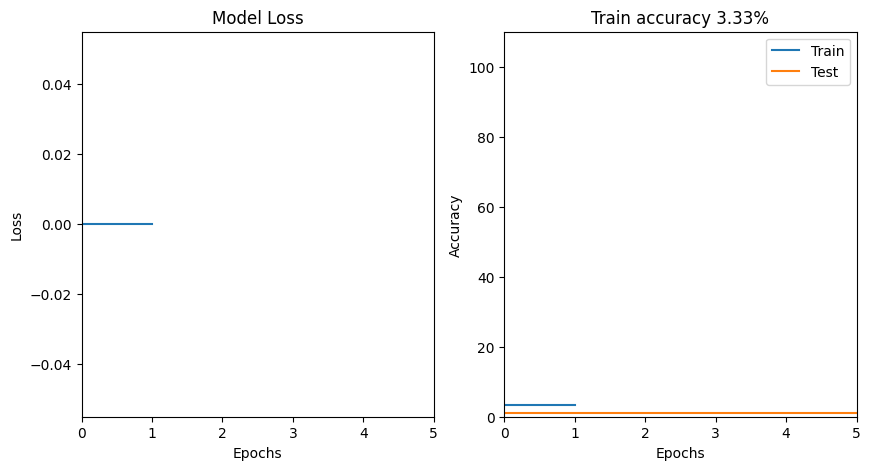

In [139]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(trainLoss, label='Train')
# ax[0].plot(testLoss, label='Dev')
# ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlim([0,5])

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Train accuracy {trainAcc[-1]:.2f}%')
ax[1].set_ylim([0,110])
ax[1].set_xlim([0,5])

plt.show()

In [ ]:
bacteria_dict = { 
     0 :"MRSA 1"
    ,1 :"MRSA 2"
    ,2 :"MSSA 1"
    ,3 :"MSSA 2"
    ,4 :"MSSA 3"
    ,5 :"S. epidermidis"
    ,6 :"S. lugdunensis"
    ,7 :"S. pneumoniae 1"
    ,8 :"S. pneumoniae 2"
    ,9 :"Group A Strep."
    ,10:"Group B Strep."
    ,11:"Group C Strep."
    ,12:"Group G Strep."
    ,13:"S. sanguinis"
    ,14:"E. faecalis 1"
    ,15:"E. faecalis 2"
    ,16:"E. faecium"
    ,17:"E. coli 1"
    ,18:"E. coli 2"
    ,19:"K. pneumoniae 1"
    ,20:"K. pneumoniae 2"
    ,21:"K. aerogenes"
    ,22:"E. cloacae"
    ,23:"P. mirabilis"
    ,24:"S. marcescens"
    ,25:"S. enterica"
    ,26:"P. aeruginosa 1"
    ,27:"P. aeruginosa 2"
    ,28:"C. albicans"
    ,29:"C. glabrata"
}

### test clinic train loader with trained model ... 
### to know which out is which! reverse engineering

In [ ]:
# train loader => 2018 clinical dataset
X_ref = np.load('data/X_2018clinical.npy')       #(10000,1000) #y(10000)
train_waveforms = X_ref.reshape(X_ref.shape[0], 1, X_ref.shape[1])
train_waveforms = torch.tensor(train_waveforms).float()
train_labels = np.load('data/y_2018clinical.npy')       #(10000,1000) #y(10000)
test_labels = np.load('data/y_test.npy')           #(3000, 1000) #y(3000)
train_labels = torch.tensor(train_labels).long()
train_dataset = TensorDataset(train_waveforms, train_labels)
batchsize    = 20
batchsize    = len(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)

for X, y in train_loader:

    X = X.to(device)
    y = y.to(device)
    trainedModel.eval()
    
    yHat = trainedModel(X)
    

# print(f'y    shape = {y.shape}')
# print(f'yHat shape = {yHat_labels.shape}')

# sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})

# label = [antibiotics[i] for i in {0,1,2,3,4,5,6}]


# cm = confusion_matrix(y, yHat_labels, labels=ab_order)
# cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]

# plt.figure(figsize=(5, 4))
# ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='1.0f',
#                  xticklabels={0,1,2,3,4,5,6}, yticklabels={0,1,2,3,4,5,6})
# ax.xaxis.tick_top()
# plt.xticks(rotation=90) 
# plt.show()




# Appendix!

In [ ]:
# train loader => 2018 clinical dataset
X_ref = np.load('data/X_2019clinical.npy')       #(10000,1000) #y(10000)
train_waveforms = X_ref.reshape(X_ref.shape[0], 1, X_ref.shape[1])
train_waveforms = torch.tensor(train_waveforms).float()
train_labels = np.load('data/y_2019clinical.npy')       #(10000,1000) #y(10000)
train_labels = torch.tensor(train_labels).long()
train_dataset = TensorDataset(train_waveforms, train_labels)
batchsize    = 20
batchsize    = len(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)

for X, y in train_loader:

    X = X.to(device)
    y = y.to(device)
    trainedModel.eval()
    
    yHat = trainedModel(X)
    
y       = y.detach().cpu().numpy()
yHat    = yHat.detach().cpu().numpy()
yHat_labels = np.argmax(yHat, axis=1)

y00,y01,y02,y03,y04,y05,y06,y07 = 0,0,0,0,0,0,0,0
y10,y11,y12,y13,y14,y15,y16,y17 = 0,0,0,0,0,0,0,0
y20,y21,y22,y23,y24,y25,y26,y27 = 0,0,0,0,0,0,0,0
y30,y31,y32,y33,y34,y35,y36,y37 = 0,0,0,0,0,0,0,0
y40,y41,y42,y43,y44,y45,y46,y47 = 0,0,0,0,0,0,0,0
y50,y51,y52,y53,y54,y55,y56,y57 = 0,0,0,0,0,0,0,0
y60,y61,y62,y63,y64,y65,y66,y67 = 0,0,0,0,0,0,0,0
occurrence_matrix = np.zeros((7, 8))

for m, n in zip(y, yHat_labels):

    # Add conditions for each combination of m and n
    if m == 0 and n == 0:
        y00 += 1
    elif m == 0 and n == 1:
        y01 += 1
    elif m == 0 and n == 2:
        y02 += 1
    elif m == 0 and n == 3:
        y03 += 1
    elif m == 0 and n == 4:
        y04 += 1
    elif m == 0 and n == 5:
        y05 += 1
    elif m == 0 and n == 6:
        y06 += 1
    elif m == 0 and n == 7:
        y07 += 1

    elif m == 1 and n == 0:
        y10 += 1
    elif m == 1 and n == 1:
        y11 += 1
    elif m == 1 and n == 2:
        y12 += 1
    elif m == 1 and n == 3:
        y13 += 1
    elif m == 1 and n == 4:
        y14 += 1
    elif m == 1 and n == 5:
        y15 += 1
    elif m == 1 and n == 6:
        y16 += 1
    elif m == 1 and n == 7:
        y17 += 1

    elif m == 2 and n == 0:
        y20 += 1
    elif m == 2 and n == 1:
        y21 += 1
    elif m == 2 and n == 2:
        y22 += 1
    elif m == 2 and n == 3:
        y23 += 1
    elif m == 2 and n == 4:
        y24 += 1
    elif m == 2 and n == 5:
        y25 += 1
    elif m == 2 and n == 6:
        y26 += 1
    elif m == 2 and n == 7:
        y27 += 1

    elif m == 3 and n == 0:
        y30 += 1
    elif m == 3 and n == 1:
        y31 += 1
    elif m == 3 and n == 2:
        y32 += 1
    elif m == 3 and n == 3:
        y33 += 1
    elif m == 3 and n == 4:
        y34 += 1
    elif m == 3 and n == 5:
        y35 += 1
    elif m == 3 and n == 6:
        y36 += 1
    elif m == 3 and n == 7:
        y37 += 1

    elif m == 4 and n == 0:
        y40 += 1
    elif m == 4 and n == 1:
        y41 += 1
    elif m == 4 and n == 2:
        y42 += 1
    elif m == 4 and n == 3:
        y43 += 1
    elif m == 4 and n == 4:
        y44 += 1
    elif m == 4 and n == 5:
        y45 += 1
    elif m == 4 and n == 6:
        y46 += 1
    elif m == 4 and n == 7:
        y47 += 1

    elif m == 5 and n == 0:
        y50 += 1
    elif m == 5 and n == 1:
        y51 += 1
    elif m == 5 and n == 2:
        y52 += 1
    elif m == 5 and n == 3:
        y53 += 1
    elif m == 5 and n == 4:
        y54 += 1
    elif m == 5 and n == 5:
        y55 += 1
    elif m == 5 and n == 6:
        y56 += 1
    elif m == 5 and n == 7:
        y57 += 1

    elif m == 6 and n == 0:
        y60 += 1
    elif m == 6 and n == 1:
        y61 += 1
    elif m == 6 and n == 2:
        y62 += 1
    elif m == 6 and n == 3:
        y63 += 1
    elif m == 6 and n == 4:
        y64 += 1
    elif m == 6 and n == 5:
        y65 += 1
    elif m == 6 and n == 6:
        y66 += 1
    elif m == 6 and n == 7:
        y67 += 1
        
print(f'y    = {y}')
print(f'yHat = {yHat_labels}')

# Print the final counts
print(f'y00: {y00}, y01: {y01}, y02: {y02}, y03: {y03}, y04: {y04}, y05: {y05}, y06: {y06}, y07: {y07}')
print(f'y10: {y10}, y11: {y11}, y12: {y12}, y13: {y13}, y14: {y14}, y15: {y15}, y16: {y16}, y17: {y17}')
print(f'y20: {y20}, y21: {y21}, y22: {y22}, y23: {y23}, y24: {y24}, y25: {y25}, y26: {y26}, y27: {y27}')
print(f'y30: {y30}, y31: {y31}, y32: {y32}, y33: {y33}, y34: {y34}, y35: {y35}, y36: {y36}, y37: {y37}')
print(f'y40: {y40}, y41: {y41}, y42: {y42}, y43: {y43}, y44: {y44}, y45: {y45}, y46: {y46}, y47: {y47}')
print(f'y50: {y50}, y51: {y51}, y52: {y52}, y53: {y53}, y54: {y54}, y55: {y55}, y56: {y56}, y57: {y57}')
print(f'y60: {y60}, y61: {y61}, y62: {y62}, y63: {y63}, y64: {y64}, y65: {y65}, y66: {y66}, y67: {y67}')

